In [1]:
import pymongo
import pandas as pd


db = pymongo.MongoClient("mongodb://127.0.0.1:27017")["radar"]
col = db["baseline_results"]
baseline_results = pd.DataFrame(col.find({}, projection={"_id": 0}))
print(len(baseline_results))

4227425


In [2]:
total_releases = len(baseline_results)
total_packages = len(baseline_results["name"].unique())
print(f"Total: {total_releases} releases,", f"{total_packages} packages")
for column in ["ossgadget", "warehouse", "librariesio", "py2src_final"]:
    releases = baseline_results[baseline_results[column] != ""][
        ["name", "version", column]
    ]
    num_packages = len(releases["name"].unique())
    print(
        f"{column}: {len(releases)} / {len(releases) / total_releases:.1%} releases,",
        f"{num_packages} / {num_packages / total_packages:.1%} packages",
    )

Total: 4227425 releases, 423726 packages
ossgadget: 3072108 / 72.7% releases, 290122 / 68.5% packages
warehouse: 3068148 / 72.6% releases, 289919 / 68.4% packages
librariesio: 3161243 / 74.8% releases, 299154 / 70.6% packages
py2src_final: 3189944 / 75.5% releases, 297443 / 70.2% packages


In [3]:
librariesio_results = baseline_results[["name", "version", "librariesio"]].copy()
librariesio_results["platform"] = librariesio_results[
    librariesio_results["librariesio"] != ""
]["librariesio"].apply(lambda x: x.split("/")[2])

platform_dist = (
    librariesio_results["platform"]
    .value_counts(dropna=False)
    .to_frame(name="num_releases")
)
platform_dist["percentage_releases"] = (
    platform_dist["num_releases"] / platform_dist["num_releases"].sum() * 100
)
platform_dist["num_packages"] = librariesio_results.groupby("platform", dropna=False)[
    "name"
].apply(lambda x: len(set(x)))
platform_dist["percentage_packages"] = (
    platform_dist["num_packages"] / platform_dist["num_packages"].sum() * 100
)
platform_dist

,num_releases,percentage_releases,num_packages,percentage_packages
github.com,3032984,71.745424,286536,63.490263
NaN,1066182,25.220601,149798,33.192040
gitlab.com,68670,1.624393,7533,1.669152
bitbucket.org,53668,1.269520,6449,1.428961
sourceforge.net,5918,0.139991,989,0.219141
svn.apache.org,2,0.000047,1,0.000222
git-wip-us.apache.org,1,0.000024,1,0.000222


In [4]:
github_results = baseline_results[
    baseline_results["librariesio"].str.startswith("https://github.com")
    | (baseline_results["librariesio"] == "")
]

data = []
baselines = ["ossgadget", "warehouse", "librariesio", "py2src_final"]
for i in range(len(baselines)):
    data.append([0] * len(baselines))

for i in range(len(baselines)):
    for j in range(i, len(baselines)):
        results_diff = len(
            github_results[github_results[baselines[i]] != github_results[baselines[j]]]
        )
        data[j][i] = results_diff / len(baseline_results)

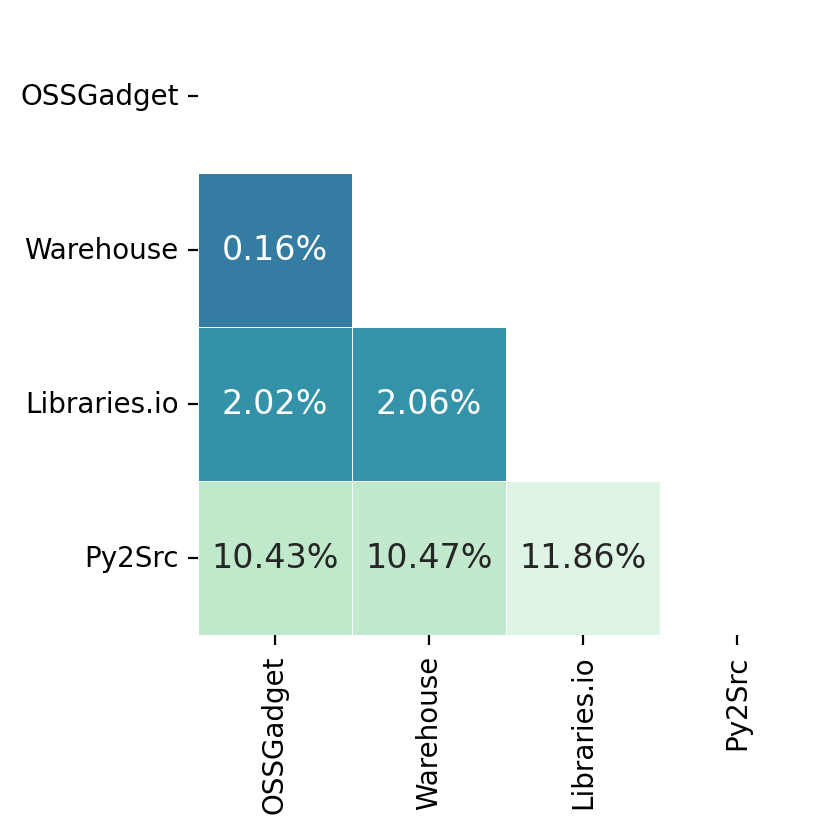

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


def plot_diff_heatmap(data):
    with sns.axes_style():
        fig, ax = plt.subplots(figsize=(4, 4))
        corr = pd.DataFrame(data, index=baselines, columns=baselines)
        mapper = {
            "ossgadget": "OSSGadget",
            "warehouse": "Warehouse",
            "librariesio": "Libraries.io",
            "py2src_final": "Py2Src",
        }
        corr.rename(index=mapper, columns=mapper, inplace=True)

        # Create a mask
        mask = np.triu(np.ones_like(corr, dtype=bool))

        # Create a custom divergin palette
        cmap = sns.color_palette("mako", as_cmap=True)

        sns.heatmap(
            corr,
            mask=mask,
            center=0,
            annot=True,
            fmt=".2%",
            square=True,
            cmap=cmap,
            ax=ax,
            cbar=False,
            linewidths=0.2,
            annot_kws={"fontsize": 12},
        )
        fig.savefig("figures/baseline_diff_heatmap.pdf", bbox_inches="tight")


plot_diff_heatmap(data)

In [6]:
baseline_diff = github_results[
    (github_results["ossgadget"] != github_results["warehouse"])
    | (github_results["ossgadget"] != github_results["librariesio"])
    | (github_results["ossgadget"] != github_results["py2src_final"])
]
print(len(baseline_diff), len(baseline_diff["name"].unique()))

511480 51456


In [7]:
diff_packages = []

for i in range(len(baselines)):
    for j in range(i + 1, len(baselines)):
        diff_packages.append(
            baseline_diff[(baseline_diff[baselines[i]] != baseline_diff[baselines[j]])][
                "name"
            ].unique()
        )

total = 0
for v in diff_packages:
    total += len(v)
print(total)
for v in diff_packages:
    print(len(v), len(v) / total * 381)

159159
930 2.2262643017359998
10454 25.025125817578648
43280 103.60507417111192
10650 25.494317003750968
43171 103.34414641961811
50674 121.30507228620436


In [8]:
sample = [2, 25, 104, 26, 103, 121]
cnt = 0
res = pd.DataFrame()
for i in range(len(baselines)):
    for j in range(i + 1, len(baselines)):
        tmp_diff = baseline_diff[
            (baseline_diff[baselines[i]] != baseline_diff[baselines[j]])
        ]
        sample_packages = np.random.choice(
            diff_packages[cnt], sample[cnt], replace=False
        )
        sample_diff = (
            tmp_diff[tmp_diff["name"].isin(sample_packages)].groupby("name").sample(1)
        )
        res = pd.concat([res, sample_diff], axis=0)
        cnt += 1
print(len(res))

381


In [15]:
diff_reasons = pd.read_csv(
    "data/baseline_diff_samples.csv", low_memory=False, keep_default_na=False
)
reason_cnt = {}
for reasons in diff_reasons["reason"].values:
    for reason in reasons.split(","):
        reason_cnt[reason] = reason_cnt.get(reason, 0) + 1
reason_cnt = sorted(reason_cnt.items(), key=lambda x: x[1], reverse=True)
reason_cnt = pd.DataFrame(
    [[k, v, 100 * v / len(diff_reasons)] for k, v in reason_cnt],
    columns=["reason", "count", "percentage"],
)
reason_cnt

,reason,count,percentage
0,URL Redirection,237,62.204724
1,Project Urls Fields,48,12.598425
2,Badge,47,12.335958
3,Readthedocs,34,8.923885
4,URL Matching,20,5.249344
5,Homepage,15,3.937008
6,URL Selection,4,1.049869
7,GitHub Reserved Names,2,0.524934
